In [1]:
%%file dist.m
function f = dist(x0,sH,pH,pL,bet,phi,rstar,yLtar,piLtar)

sL = x0(1);
kap = x0(2);

% 解析的解
A = [-1+(1-pH) pH -(phi-1)*(1-pH) -(phi-1)*pH;
    kap 0 -1+bet*(1-pH) bet*pH;
    (1-pL) -1+pL (1-pL) pL;
    0 kap bet*(1-pL) -1+bet*pL];
b = [rstar-sH;0;-sL;0];
x = A\b;
%yH  = x(1);
yL  = x(2);
%piH = x(3);
piL = x(4);

% データの値とモデルの値の間の距離を最小化
f = (yL-yLtar)^2 + (piL-piLtar)^2;

Created file '/home/takeki/Documents/keizai-seminar/chapter5/Matlab/1_TwostateNK/dist.m'.


In [22]:
%%file ti.m
function [yvec0 pvec0 rvec0] = ti(m)

% disp('')
% disp('-+- Solve a two-state model with time iteration -+-');

%% STEP 1(a): グリッド生成
Gs = [m.sH; m.sL];
Ps = [1-m.pH m.pH;
    1-m.pL m.pL]; 

%% 解析的解
A = [-1+(1-m.pH) m.pH -(m.phi-1)*(1-m.pH) -(m.phi-1)*m.pH;
m.kap 0 -1+m.bet*(1-m.pH) m.bet*m.pH;
(1-m.pL) -1+m.pL (1-m.pL) m.pL;
0 m.kap m.bet*(1-m.pL) -1+m.bet*m.pL];
b = [m.rstar-m.sH;0;-m.sL;0];
x = A\b;
yH  = x(1);
yL  = x(2);
piH = x(3);
piL = x(4);
rH = m.rstar + m.phi*((1-m.pH)*piH + m.pH*piL);

%% STEP 1(b): 政策関数の初期値を当て推量
Ns = 2;
% 解析的解を初期値とする(1回の繰り返しで収束)
% yvec0 = [yH; yL];
% pvec0 = [piH; piL];
% rvec0 = [rH; 0];
% 適当な初期値
yvec0 = zeros(Ns,1);
pvec0 = zeros(Ns,1);
rvec0 = zeros(Ns,1);
yvec1 = zeros(Ns,1);
pvec1 = zeros(Ns,1);
rvec1 = zeros(Ns,1);

%% STEP 4: 政策関数を繰り返し計算
diff = 1e+4; % 政策関数の繰り返し誤差
iter = 1; % ループ・カウンター

while(diff > m.tol)

    for is = 1:Ns

        % ショックの値
        s0 = Gs(is);

        % 古い政策関数から期待値(ye, pie)を計算
        ye = Ps(is,:)*yvec0;
        pie = Ps(is,:)*pvec0;

        % 期待値を所与として最適化
        r0 = max(m.rstar + m.phi*pie, 0);
        y0 = ye - (r0 - pie - s0);
        p0 = m.kap*y0 + m.bet*pie;

        % 新しい政策関数を保存
        yvec1(is,1) = y0;
        pvec1(is,1) = p0;
        rvec1(is,1) = r0;

    end
    
    % 繰り返し計算誤差を確認
    ydiff = max(abs(yvec1-yvec0));
    pdiff = max(abs(pvec1-pvec0));
    rdiff = max(abs(rvec1-rvec0));
    diff = max([ydiff pdiff rdiff]);

    disp([iter diff]);

    % 政策関数をアップデート
    yvec0 = yvec1;
    pvec0 = pvec1;
    rvec0 = rvec1;
    
    iter = iter + 1;
    
end

Created file '/home/takeki/Documents/keizai-seminar/chapter5/Matlab/1_TwostateNK/ti.m'.


In [23]:
m.rstar = 0.75; % pH=0のときの、定常状態での名目金利の値
m.bet = 1/(1+m.rstar/100); % 割引率(オイラー方程式の定常状態より)
m.phi = 5.0;  % テイラー係数(注: 小さいとiL=0にならない)
m.pL = 0.75;  % 危機の継続確率
m.sH = m.rstar; % 状態Hでの自然利子率の値

% カリブレーション
% yLとpiLのターゲットにpH=0のときのモデルの値を合わせるように、sLとkapの値をセット

m.pH = 0.0; % 危機が起こる確率
x0 = [-2.0, 0.01]; % sLとkapの初期値

% yLとpiLのターゲット
yLtar = -7.0;
piLtar = -1.0/4;

% 最小化関数(Matlabの場合fminsearch)を用いる
x = fminsearch(@dist,x0,[],m.sH,m.pH,m.pL,m.bet,m.phi,m.rstar,yLtar,piLtar);

% カリブレートしたパラメータをセット
m.sL = x(1); % 状態Lでの自然利子率の値
m.kap = x(2); % フィリップス曲線の傾き

m.maxiter = 2000; % 繰り返し回数の最大値
m.tol = 1e-5; % 許容誤差

m


m = 

  struct with fields:

      rstar: 0.7500
        bet: 0.9926
        phi: 5
         pL: 0.7500
         sH: 0.7500
         pH: 0
         sL: -1.5625
        kap: 0.0091
    maxiter: 2000
        tol: 1.0000e-05



In [24]:
tic;
[yvec0 pvec0 rvec0] = ti(m);
toc;

    1.0000    2.3125

    2.0000    1.6711

    3.0000    1.1604

    4.0000    0.7694

    5.0000    0.4809

    6.0000    0.2759

    7.0000    0.1363

    8.0000    0.0704

    9.0000    0.0437

   10.0000    0.0092

   11.0000    0.0129

   12.0000    0.0143

   13.0000    0.0142

   14.0000    0.0134

   15.0000    0.0122

   16.0000    0.0108

   17.0000    0.0094

   18.0000    0.0081

   19.0000    0.0069

   20.0000    0.0058

   21.0000    0.0049

   22.0000    0.0041

   23.0000    0.0034

   24.0000    0.0029

   25.0000    0.0024

   26.0000    0.0020

   27.0000    0.0016

   28.0000    0.0013

   29.0000    0.0011

   30.0000    0.0009

   31.0000    0.0008

   32.0000    0.0006

   33.0000    0.0005

   34.0000    0.0004

   35.0000    0.0003

   36.0000    0.0003

   37.0000    0.0002

   38.0000    0.0002

   39.0000    0.0002

   40.0000    0.0001

   41.0000    0.0001

   42.0000    0.0001

   43.0000    0.0001

   44.0000    0.0001

   45.0000    0.0000

   46.0000

In [25]:
m.pH = 0.025
tic;
[yvec1 pvec1 rvec1] = ti(m);
toc;


m = 

  struct with fields:

      rstar: 0.7500
        bet: 0.9926
        phi: 5
         pL: 0.7500
         sH: 0.7500
         pH: 0.0250
         sL: -1.5625
        kap: 0.0091
    maxiter: 2000
        tol: 1.0000e-05

    1.0000    2.3125

    2.0000    1.6711

    3.0000    1.1733

    4.0000    0.7976

    5.0000    0.5199

    6.0000    0.3174

    7.0000    0.1707

    8.0000    0.1024

    9.0000    0.1013

   10.0000    0.0904

   11.0000    0.0729

   12.0000    0.1028

   13.0000    0.1292

   14.0000    0.1512

   15.0000    0.1682

   16.0000    0.1797

   17.0000    0.1854

   18.0000    0.1852

   19.0000    0.1792

   20.0000    0.1676

   21.0000    0.1509

   22.0000    0.1515

   23.0000    0.1515

   24.0000    0.1468

   25.0000    0.1374

   26.0000    0.1238

   27.0000    0.1064

   28.0000    0.0859

   29.0000    0.0742

   30.0000    0.0998

   31.0000    0.1218

   32.0000    0.1397

   33.0000    0.1530

   34.0000    0.1612

   35.0000    0.1641

 

  365.0000    0.0116

  366.0000    0.0134

  367.0000    0.0147

  368.0000    0.0156

  369.0000    0.0159

  370.0000    0.0158

  371.0000    0.0151

  372.0000    0.0140

  373.0000    0.0128

  374.0000    0.0131

  375.0000    0.0130

  376.0000    0.0124

  377.0000    0.0115

  378.0000    0.0102

  379.0000    0.0086

  380.0000    0.0068

  381.0000    0.0071

  382.0000    0.0092

  383.0000    0.0110

  384.0000    0.0124

  385.0000    0.0134

  386.0000    0.0140

  387.0000    0.0141

  388.0000    0.0138

  389.0000    0.0130

  390.0000    0.0118

  391.0000    0.0115

  392.0000    0.0116

  393.0000    0.0113

  394.0000    0.0107

  395.0000    0.0097

  396.0000    0.0085

  397.0000    0.0070

  398.0000    0.0053

  399.0000    0.0071

  400.0000    0.0088

  401.0000    0.0103

  402.0000    0.0114

  403.0000    0.0121

  404.0000    0.0124

  405.0000    0.0124

  406.0000    0.0119

  407.0000    0.0111

  408.0000    0.0099

  409.0000    0.0102

  410.0000

  738.0000    0.0012

  739.0000    0.0012

  740.0000    0.0012

  741.0000    0.0011

  742.0000    0.0010

  743.0000    0.0010

  744.0000    0.0010

  745.0000    0.0010

  746.0000    0.0009

  747.0000    0.0008

  748.0000    0.0007

  749.0000    0.0006

  750.0000    0.0005

  751.0000    0.0007

  752.0000    0.0008

  753.0000    0.0009

  754.0000    0.0010

  755.0000    0.0011

  756.0000    0.0011

  757.0000    0.0011

  758.0000    0.0010

  759.0000    0.0009

  760.0000    0.0009

  761.0000    0.0009

  762.0000    0.0009

  763.0000    0.0008

  764.0000    0.0008

  765.0000    0.0007

  766.0000    0.0006

  767.0000    0.0004

  768.0000    0.0005

  769.0000    0.0006

  770.0000    0.0008

  771.0000    0.0008

  772.0000    0.0009

  773.0000    0.0009

  774.0000    0.0009

  775.0000    0.0009

  776.0000    0.0009

  777.0000    0.0008

  778.0000    0.0008

  779.0000    0.0008

  780.0000    0.0008

  781.0000    0.0007

  782.0000    0.0006

  783.0000

   1.0e+03 *

    1.0720    0.0000

   1.0e+03 *

    1.0730    0.0000

   1.0e+03 *

    1.0740    0.0000

   1.0e+03 *

    1.0750    0.0000

   1.0e+03 *

    1.0760    0.0000

   1.0e+03 *

    1.0770    0.0000

   1.0e+03 *

    1.0780    0.0000

   1.0e+03 *

    1.0790    0.0000

   1.0e+03 *

    1.0800    0.0000

   1.0e+03 *

    1.0810    0.0000

   1.0e+03 *

    1.0820    0.0000

   1.0e+03 *

    1.0830    0.0000

   1.0e+03 *

    1.0840    0.0000

   1.0e+03 *

    1.0850    0.0000

   1.0e+03 *

    1.0860    0.0000

   1.0e+03 *

    1.0870    0.0000

   1.0e+03 *

    1.0880    0.0000

   1.0e+03 *

    1.0890    0.0000

   1.0e+03 *

    1.0900    0.0000

   1.0e+03 *

    1.0910    0.0000

   1.0e+03 *

    1.0920    0.0000

   1.0e+03 *

    1.0930    0.0000

   1.0e+03 *

    1.0940    0.0000

   1.0e+03 *

    1.0950    0.0000

   1.0e+03 *

    1.0960    0.0000

   1.0e+03 *

    1.0970    0.0000

   1.0e+03 *

    1.0980    0.0000

   1.0e+03 *

    1.0990    

    1.3240    0.0000

   1.0e+03 *

    1.3250    0.0000

   1.0e+03 *

    1.3260    0.0000

   1.0e+03 *

    1.3270    0.0000

   1.0e+03 *

    1.3280    0.0000

   1.0e+03 *

    1.3290    0.0000

   1.0e+03 *

    1.3300    0.0000

Elapsed time is 0.321582 seconds.


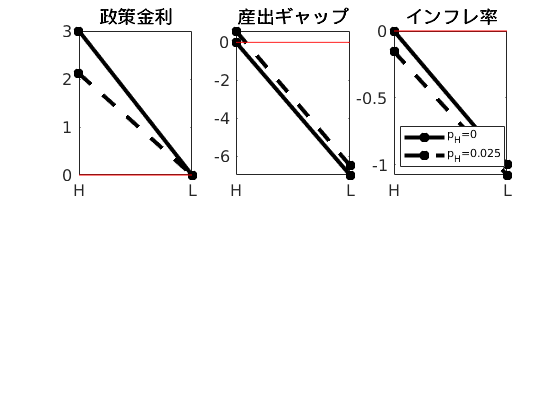

In [28]:
xvec = [0 1];

figure;
subplot(231);
plot(xvec,rvec0*4,'k*-','LineWidth',3.0);
hold on;
plot(xvec,rvec1*4,'k*--','LineWidth',3.0);
plot(xvec,[0 0],'r-');
title('政策金利');
xticks([0 1]);
xticklabels({'H','L'});
set(gca,'Fontsize',12);

subplot(232);
plot(xvec,yvec0,'k*-','LineWidth',3.0);
hold on;
plot(xvec,yvec1,'k*--','LineWidth',3.0);
plot(xvec,[0 0],'r-');
title('産出ギャップ');
xticks([0 1]);
xticklabels({'H','L'});
set(gca,'Fontsize',12);

subplot(233);
plot(xvec,pvec0*4,'k*-','LineWidth',3.0);
hold on;
plot(xvec,pvec1*4,'k*--','LineWidth',3.0);
plot(xvec,[0 0],'r-');
title('インフレ率');
xticks([0 1]);
xticklabels({'H','L'});
set(gca,'Fontsize',12);
m = legend('p_H=0','p_H=0.025','Location','SouthWest');
m.FontSize = 8;
% saveas(gcf,'simplepf.eps','epsc2');